In [2]:
from scipy.sparse import data
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as sp
import scipy.io as sio
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from datetime import datetime
import argparse
from model import Dominant
from torch_geometric.nn import SAGEConv, GATConv, DenseSAGEConv, DenseGATConv
from time import process_time_ns 

In [18]:
datum = [f'data/ACM.mat', f'data/Flickr.mat', f'data/BlogCatalog.mat']
for data in datum:
    print(data, ": ")
    print("avg. degree: ", getAverageDegree(data), "\n\n")
    

data/ACM.mat : 
total nodes:  16484
normal nodes:  15887
anomalous nodes:  597
avg. degree:  9.970274205289979 


data/Flickr.mat : 
total nodes:  7575
normal nodes:  7130
anomalous nodes:  445
avg. degree:  63.703630363036304 


data/BlogCatalog.mat : 
total nodes:  5196
normal nodes:  4898
anomalous nodes:  298
avg. degree:  66.49711316397229 




In [3]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    #co ordinate matrix 
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def load_anomaly_detection_dataset(dataset, datadir='data'):
    
    data_mat = sio.loadmat(f'{datadir}/{dataset}.mat')
    adj = data_mat['Network']
    feat = data_mat['Attributes']
    truth = data_mat['Label']
    truth = truth.flatten()

    adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_norm = adj_norm.toarray()
    adj = adj + sp.eye(adj.shape[0])
    adj = adj.toarray()
    feat = feat.toarray()
    return adj_norm, feat, truth, adj

In [4]:
import math

from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    # Initializes the GCN layer with input and output feature dimensions,
    # and an optional bias term.
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Define the weight matrix as a learnable parameter of shape (in_features, out_features)
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    
    # Initialize the weights and biases using a uniform distribution
    # with range determined by the inverse square root of the number of output features.

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # linear transformation of the input features using the weight matrix.
        support = torch.mm(input, self.weight)
        
        # apply the adjacency matrix to the transformed features to propagate the features across the graph
        output = torch.spmm(adj, support) if adj.is_sparse else torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output


    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Encoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Encoder, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        I = torch.eye(adj.size(0)).to(adj.device)
        if adj.is_sparse:
            I = I.to_sparse()
        adj_with_self_loops = adj + I
        
        x = F.relu(self.gc1(x, adj_with_self_loops))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj_with_self_loops))

        return x

class Attribute_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Attribute_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))

        return x

class Structure_Decoder(nn.Module):
    def __init__(self, nhid, dropout):
        super(Structure_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = x @ x.T        #this is matrix multiplication

        return x

class Dominant(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant, self).__init__()
        
        self.shared_encoder = Encoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## GAT Encoder

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, N, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [7]:
class GATEncoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout, alpha=0.2, concat=True):
        super(GATEncoder, self).__init__()
        self.gat1 = GATLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=concat)
        self.gat2 = GATLayer(nhid, nhid, dropout=dropout, alpha=alpha, concat=False)  # For the second layer, we might not want to concatenate features
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat1(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat2(x, adj)
        return x

class Dominant_GAT(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_GAT, self).__init__()
        
        self.shared_encoder = GATEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## GAT Encoder using pgG GATConvLayer

In [8]:
class pyGATEncoder(Module):
    def __init__(self, in_features, out_features, dropout, concat=True):
        super(pyGATEncoder, self).__init__()
        self.gat1 = GATConv(in_features, out_features, concat=concat)
        self.gat2 = GATConv(out_features, out_features, concat=False)
        self.dropout = dropout

    def forward(self, x, adj):
        edge_index = adj.nonzero().t().contiguous()
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

class Dominant_pyGGAT(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_pyGGAT, self).__init__()
        
        self.shared_encoder = pyGATEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## WIP: DenseGAT Encoder using pgG DenseGATConv Layer

In [9]:
class pyDenseGATEncoder(Module):
    def __init__(self, in_features, out_features, dropout, concat=True):
        super(pyDenseGATEncoder, self).__init__()
        self.dense_gat1 = DenseGATConv(in_features, out_features, concat=concat)
        self.dense_gat2 = DenseGATConv(out_features, out_features, concat=False)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.dense_gat1(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.dense_gat2(x, adj)
        return x

class Dominant_pyGDenseGAT(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_pyGDenseGAT, self).__init__()
        
        self.shared_encoder = pyDenseGATEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## GraphSAGE Encoder using pgG SAGEConv Layer

In [10]:
class GraphSAGEEncoder(Module):
    def __init__(self, in_features, out_features, dropout):
        super(GraphSAGEEncoder, self).__init__()
        # Define two GraphSAGE convolutional layers
        self.sage1 = SAGEConv(in_features, out_features)
        self.sage2 = SAGEConv(out_features, out_features)
        self.dropout = dropout

    def forward(self, x, adj):
        edge_index = adj.nonzero().t().contiguous()
        # Apply the first GraphSAGE layer and a ReLU activation
        x = F.relu(self.sage1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Apply the second GraphSAGE layer
        x = self.sage2(x, edge_index)
        
        return x


class Dominant_GraphSAGE(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_GraphSAGE, self).__init__()
        
        self.shared_encoder = GraphSAGEEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## WIP: DenseGrpahSAGE Encoder using pgG DenseSAGEConv Layer

In [11]:
class DenseSAGEEncoder(Module):
    def __init__(self, in_features, out_features, dropout):
        super(DenseSAGEEncoder, self).__init__()
        # Define two GraphSAGE convolutional layers
        self.dense_sage1 = DenseSAGEConv(in_features, out_features)
        self.dense_sage2 = DenseSAGEConv(out_features, out_features)
        self.dropout = dropout

    def forward(self, x, adj):
#         edge_index = adj.nonzero().t().contiguous()
        # Apply the first GraphSAGE layer and a ReLU activation
        x = F.relu(self.dense_sage1(x, adj))
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Apply the second GraphSAGE layer
        x = self.dense_sage2(x, adj)
        
        return x


class Dominant_DenseSAGE(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_DenseSAGE, self).__init__()
        
        self.shared_encoder = DenseSAGEEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

In [12]:
def loss_func(adj, A_hat, attrs, X_hat, alpha):
    # Attribute reconstruction loss
    diff_attribute = torch.pow(X_hat - attrs, 2)
    attribute_reconstruction_errors = torch.sqrt(torch.sum(diff_attribute, 1))
    attribute_cost = torch.mean(attribute_reconstruction_errors)

    # structure reconstruction loss
    diff_structure = torch.pow(A_hat - adj, 2)
    structure_reconstruction_errors = torch.sqrt(torch.sum(diff_structure, 1))
    structure_cost = torch.mean(structure_reconstruction_errors)


    cost =  alpha * attribute_reconstruction_errors + (1-alpha) * structure_reconstruction_errors

    return cost, structure_cost, attribute_cost

In [32]:
def train_dominant(encoder="OG", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="cpu"):
    adj, attrs, label, adj_label = load_anomaly_detection_dataset(dataset)
    adj = torch.FloatTensor(adj)
    adj_label = torch.FloatTensor(adj_label)
    attrs = torch.FloatTensor(attrs)
    start_time = process_time_ns()
    if encoder == "OG":
        model = Dominant(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "GAT":
        model = Dominant_GAT(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "pyGGAT":
        model= Dominant_pyGGAT(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "GraphSAGE":
        model = Dominant_GraphSAGE(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "DenseSage":
        model = Dominant_DenseSAGE(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "DenseGAT":
        model = Dominant_pyGDenseGAT(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    else:
        print("Invalid Encoder specified\n")
        return

    if device == 'cuda':
        device = torch.device(device)
        adj = adj.to(device)
        adj_label = adj_label.to(device)
        attrs = attrs.to(device)
        model = model.cuda() 
        
    
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
    loss_dict = {
        "struct_loss": [],
        "feat_loss": [],
        "loss": []
    }
    for epoch in range(max_epoch):
        model.train()
        optimizer.zero_grad()
        # returns the reconstructed matrices
        A_hat, X_hat = model(attrs, adj)
        loss, struct_loss, feat_loss = loss_func(adj_label, A_hat, attrs, X_hat, alpha)
        l = torch.mean(loss)
        l.backward()
        optimizer.step()        
#         print("Epoch:", '%04d' % (epoch), 
#               "train_loss=", "{:.5f}".format(l.item()), 
#               "train/struct_loss=", "{:.5f}".format(struct_loss.item()),
#               "train/feat_loss=", "{:.5f}".format(feat_loss.item()))
        loss_dict["struct_loss"].append(struct_loss.item())
        loss_dict["feat_loss"].append(feat_loss.item())
        loss_dict["loss"].append(l.item())
        if epoch%10 == 0 or epoch == max_epoch - 1:
            model.eval()
            score = loss.detach().cpu().numpy()
            normalizedScore = (score - np.min(score))/(np.max(score)-np.min(score))
            precision, recall, thresholds = precision_recall_curve(label, normalizedScore) #modified 
            print("Epoch:", '%04d' % (epoch), 
                  "train_loss=", "{:.5f}".format(l.item()), 
                  "train/struct_loss=", "{:.5f}".format(struct_loss.item()),
                  "train/feat_loss=", "{:.5f}".format(feat_loss.item()),
                  'Auc', roc_auc_score(label, score))
#     return label, score
    end_time = process_time_ns()
    response = {
        "loss_dict": loss_dict,
        "time_elapsed": end_time - start_time,
        "PR_curve": {
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
    }
    return response

In [33]:
OG_response = train_dominant(encoder="OG",dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 5.40353 train/struct_loss= 21.97941 train/feat_loss= 1.25956 Auc 0.755572744388204
Epoch: 0010 train_loss= 2.47462 train/struct_loss= 7.67452 train/feat_loss= 1.17464 Auc 0.8135144874911278
Epoch: 0020 train_loss= 2.47310 train/struct_loss= 7.66699 train/feat_loss= 1.17463 Auc 0.8134124050084818
Epoch: 0030 train_loss= 2.47038 train/struct_loss= 7.65338 train/feat_loss= 1.17463 Auc 0.8137748320777416
Epoch: 0040 train_loss= 2.46979 train/struct_loss= 7.65043 train/feat_loss= 1.17463 Auc 0.8138419735763947
Epoch: 0050 train_loss= 2.46930 train/struct_loss= 7.64800 train/feat_loss= 1.17463 Auc 0.8138837657337197
Epoch: 0060 train_loss= 2.46941 train/struct_loss= 7.64853 train/feat_loss= 1.17463 Auc 0.8138597866270578
Epoch: 0070 train_loss= 2.46900 train/struct_loss= 7.64647 train/feat_loss= 1.17463 Auc 0.8141674043096622
Epoch: 0080 train_loss= 2.46890 train/struct_loss= 7.64597 train/feat_loss= 1.17463 Auc 0.813922474863045
Epoch: 0090 train_loss= 2.46853 train/

In [34]:
pyGAT_response = train_dominant(encoder="pyGGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 3.52915 train/struct_loss= 12.62698 train/feat_loss= 1.25470 Auc 0.7952300761028334
Epoch: 0010 train_loss= 2.48083 train/struct_loss= 7.70595 train/feat_loss= 1.17455 Auc 0.8132356447365177
Epoch: 0020 train_loss= 2.47148 train/struct_loss= 7.65930 train/feat_loss= 1.17452 Auc 0.81388171038172
Epoch: 0030 train_loss= 2.46904 train/struct_loss= 7.64715 train/feat_loss= 1.17451 Auc 0.8137899046590718
Epoch: 0040 train_loss= 2.46828 train/struct_loss= 7.64336 train/feat_loss= 1.17451 Auc 0.813748112501747
Epoch: 0050 train_loss= 2.46812 train/struct_loss= 7.64256 train/feat_loss= 1.17451 Auc 0.8138577312750581
Epoch: 0060 train_loss= 2.46743 train/struct_loss= 7.63912 train/feat_loss= 1.17451 Auc 0.8139330941817096
Epoch: 0070 train_loss= 2.46730 train/struct_loss= 7.63848 train/feat_loss= 1.17451 Auc 0.8139995505630294
Epoch: 0080 train_loss= 2.46705 train/struct_loss= 7.63720 train/feat_loss= 1.17451 Auc 0.8140605260056838
Epoch: 0090 train_loss= 2.46687 train/s

In [47]:
GraphSAGE_response = train_dominant(encoder="GraphSAGE",dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 5.30873 train/struct_loss= 21.52270 train/feat_loss= 1.25524 Auc 0.7606330210111785
Epoch: 0010 train_loss= 2.47587 train/struct_loss= 7.68105 train/feat_loss= 1.17458 Auc 0.8132349596191843
Epoch: 0020 train_loss= 2.48359 train/struct_loss= 7.71969 train/feat_loss= 1.17456 Auc 0.8130814933365488
Epoch: 0030 train_loss= 2.48374 train/struct_loss= 7.72046 train/feat_loss= 1.17456 Auc 0.8130568291125537
Epoch: 0040 train_loss= 2.48374 train/struct_loss= 7.72046 train/feat_loss= 1.17456 Auc 0.8130547737605544
Epoch: 0050 train_loss= 2.48374 train/struct_loss= 7.72046 train/feat_loss= 1.17456 Auc 0.8130527184085546
Epoch: 0060 train_loss= 2.47533 train/struct_loss= 7.67843 train/feat_loss= 1.17456 Auc 0.8136001271577771
Epoch: 0070 train_loss= 2.48374 train/struct_loss= 7.72046 train/feat_loss= 1.17456 Auc 0.8130527184085545
Epoch: 0080 train_loss= 2.48374 train/struct_loss= 7.72046 train/feat_loss= 1.17456 Auc 0.813053403525888
Epoch: 0090 train_loss= 2.48374 train

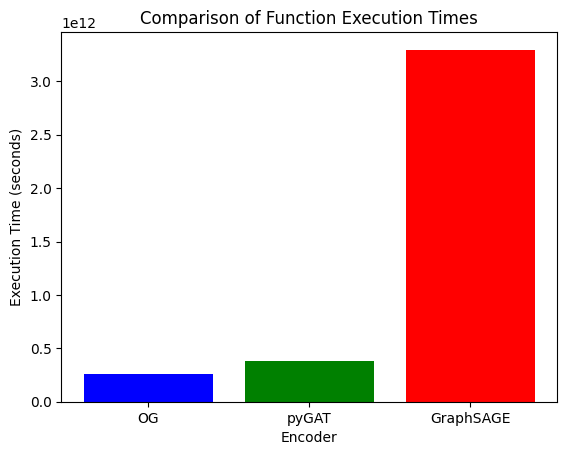

In [52]:
import matplotlib.pyplot as plt

# Function names
functions = ['OG', 'pyGAT', 'GraphSAGE']

# Execution times for each function
execution_times = [
    OG_response["time_elapsed"],
    pyGAT_response["time_elapsed"],
    GraphSAGE_response["time_elapsed"]
]

# Creating the bar chart
plt.bar(functions, execution_times, color=['blue', 'green', 'red'])

plt.xlabel('Encoder')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Function Execution Times')
plt.show()


In [50]:
def plot_losses():
    # Example data setup
    epochs = list(range(1, 101))  # Assuming 100 epochs

    # Assuming data for each function (func1, func2, func3) and each type of loss
    # Replace these with your actual data
    loss_data = {
        'OG': {
            'loss': OG_response["loss_dict"]["loss"],
            'struct_loss': OG_response["loss_dict"]["struct_loss"],
            'feat_loss': OG_response["loss_dict"]["feat_loss"],
        },
        'pyGAT': {
            'loss': pyGAT_response["loss_dict"]["loss"],
            'struct_loss': pyGAT_response["loss_dict"]["struct_loss"],
            'feat_loss': pyGAT_response["loss_dict"]["feat_loss"],
        },
        'GraphSAGE': {
            'loss': GraphSAGE_response["loss_dict"]["loss"],
            'struct_loss': GraphSAGE_response["loss_dict"]["struct_loss"],
            'feat_loss': GraphSAGE_response["loss_dict"]["feat_loss"],
        }
    }

    # Creating a figure with subplots for each type of loss
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    # Loss names for titles and iteration
    loss_types = ['loss', 'struct_loss', 'feat_loss']

    # Colors for each function
    colors = ['blue', 'green', 'red']
    function_names = ['OG', 'pyGAT', 'GraphSAGE']

    # Plotting data for each type of loss across all functions
    for i, loss_type in enumerate(loss_types):
        for func_name, color in zip(function_names, colors):
            axs[i].plot(epochs, loss_data[func_name][loss_type], label=func_name, color=color)

        axs[i].set_title(f'{loss_type.capitalize()} Comparison')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss Value')
        axs[i].legend()

    # Adjust layout
#     plt.tight_layout(pad=3.0)

    # Show the plot
    plt.show()

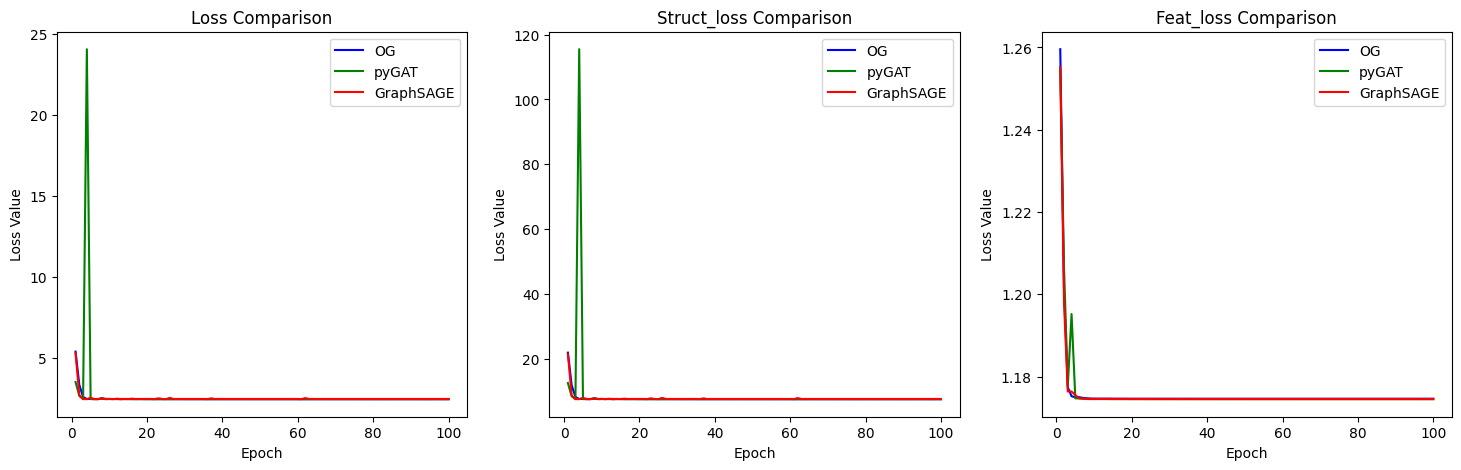

In [51]:
plot_losses()

In [41]:
pyGAT_response["loss_dict"]["loss"]

[3.52915358543396,
 2.6699368953704834,
 2.47354793548584,
 24.051544189453125,
 2.471971273422241,
 2.481118679046631,
 2.4829139709472656,
 2.4834539890289307,
 2.4835879802703857,
 2.4831602573394775,
 2.4808285236358643,
 2.4755706787109375,
 2.4718868732452393,
 2.4805285930633545,
 2.474663734436035,
 2.4706850051879883,
 2.470874309539795,
 2.4715564250946045,
 2.469951629638672,
 2.4705374240875244,
 2.4714772701263428,
 2.4691684246063232,
 2.4689483642578125,
 2.469027519226074,
 2.469649076461792,
 2.4692981243133545,
 2.468510627746582,
 2.468695640563965,
 2.468609094619751,
 2.469146490097046,
 2.469041347503662,
 2.4691054821014404,
 2.4688165187835693,
 2.468752145767212,
 2.4683568477630615,
 2.468144178390503,
 2.46884822845459,
 2.46816349029541,
 2.4682648181915283,
 2.4684689044952393,
 2.468280076980591,
 2.4682114124298096,
 2.4684877395629883,
 2.4681806564331055,
 2.4682083129882812,
 2.468263864517212,
 2.468032121658325,
 2.4681508541107178,
 2.46828436851501

In [31]:
len(OG_response["loss_dict"]["loss"][1])

5196

In [ ]:
GAT_response = train_dominant(encoder="GAT", dataset="BlogCatalog", hidden_dim=32, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

In [1]:
DenseGAT_response = train_dominant(encoder="DenseGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

NameError: name 'train_dominant' is not defined

In [ ]:
DenseSAGE_response = train_dominant(encoder="DenseSage", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

In [13]:
train_dominant(dataset="BlogCatalog", hidden_dim=64, max_epoch=500, lr=5e-4, dropout=0.3, alpha=0.8, device="cpu")

Epoch: 0000 train_loss= 3.80194 train/struct_loss= 13.96719 train/feat_loss= 1.26063
Epoch: 0000 Auc 0.8076820836336431
Epoch: 0001 train_loss= 3.63766 train/struct_loss= 13.25442 train/feat_loss= 1.23347
Epoch: 0002 train_loss= 3.53396 train/struct_loss= 12.81713 train/feat_loss= 1.21317
Epoch: 0003 train_loss= 3.41595 train/struct_loss= 12.28494 train/feat_loss= 1.19870
Epoch: 0004 train_loss= 3.30913 train/struct_loss= 11.79079 train/feat_loss= 1.18872
Epoch: 0005 train_loss= 3.22164 train/struct_loss= 11.37924 train/feat_loss= 1.18224
Epoch: 0006 train_loss= 3.14188 train/struct_loss= 10.99608 train/feat_loss= 1.17834
Epoch: 0007 train_loss= 3.07212 train/struct_loss= 10.65597 train/feat_loss= 1.17615
Epoch: 0008 train_loss= 2.99504 train/struct_loss= 10.27493 train/feat_loss= 1.17507
Epoch: 0009 train_loss= 2.93523 train/struct_loss= 9.97784 train/feat_loss= 1.17458
Epoch: 0010 train_loss= 2.87493 train/struct_loss= 9.67710 train/feat_loss= 1.17438
Epoch: 0010 Auc 0.80831581716684

Epoch: 0094 train_loss= 2.46428 train/struct_loss= 7.62543 train/feat_loss= 1.17400
Epoch: 0095 train_loss= 2.46446 train/struct_loss= 7.62631 train/feat_loss= 1.17400
Epoch: 0096 train_loss= 2.46435 train/struct_loss= 7.62578 train/feat_loss= 1.17399
Epoch: 0097 train_loss= 2.46421 train/struct_loss= 7.62509 train/feat_loss= 1.17399
Epoch: 0098 train_loss= 2.46424 train/struct_loss= 7.62525 train/feat_loss= 1.17399
Epoch: 0099 train_loss= 2.46420 train/struct_loss= 7.62506 train/feat_loss= 1.17399
Epoch: 0100 train_loss= 2.46437 train/struct_loss= 7.62591 train/feat_loss= 1.17399
Epoch: 0100 Auc 0.81424310977498
Epoch: 0101 train_loss= 2.46432 train/struct_loss= 7.62566 train/feat_loss= 1.17399
Epoch: 0102 train_loss= 2.46430 train/struct_loss= 7.62555 train/feat_loss= 1.17399
Epoch: 0103 train_loss= 2.46438 train/struct_loss= 7.62595 train/feat_loss= 1.17399
Epoch: 0104 train_loss= 2.46415 train/struct_loss= 7.62481 train/feat_loss= 1.17399
Epoch: 0105 train_loss= 2.46423 train/struc

Epoch: 0188 train_loss= 2.46348 train/struct_loss= 7.62169 train/feat_loss= 1.17393
Epoch: 0189 train_loss= 2.46333 train/struct_loss= 7.62091 train/feat_loss= 1.17393
Epoch: 0190 train_loss= 2.46346 train/struct_loss= 7.62160 train/feat_loss= 1.17393
Epoch: 0190 Auc 0.8143475901682923
Epoch: 0191 train_loss= 2.46331 train/struct_loss= 7.62085 train/feat_loss= 1.17393
Epoch: 0192 train_loss= 2.46333 train/struct_loss= 7.62093 train/feat_loss= 1.17393
Epoch: 0193 train_loss= 2.46315 train/struct_loss= 7.62006 train/feat_loss= 1.17393
Epoch: 0194 train_loss= 2.46318 train/struct_loss= 7.62020 train/feat_loss= 1.17393
Epoch: 0195 train_loss= 2.46322 train/struct_loss= 7.62041 train/feat_loss= 1.17393
Epoch: 0196 train_loss= 2.46329 train/struct_loss= 7.62076 train/feat_loss= 1.17393
Epoch: 0197 train_loss= 2.46322 train/struct_loss= 7.62041 train/feat_loss= 1.17393
Epoch: 0198 train_loss= 2.46355 train/struct_loss= 7.62207 train/feat_loss= 1.17393
Epoch: 0199 train_loss= 2.46353 train/str

Epoch: 0282 train_loss= 2.46259 train/struct_loss= 7.61745 train/feat_loss= 1.17388
Epoch: 0283 train_loss= 2.46259 train/struct_loss= 7.61744 train/feat_loss= 1.17387
Epoch: 0284 train_loss= 2.46251 train/struct_loss= 7.61707 train/feat_loss= 1.17387
Epoch: 0285 train_loss= 2.46260 train/struct_loss= 7.61750 train/feat_loss= 1.17387
Epoch: 0286 train_loss= 2.46252 train/struct_loss= 7.61713 train/feat_loss= 1.17387
Epoch: 0287 train_loss= 2.46256 train/struct_loss= 7.61729 train/feat_loss= 1.17387
Epoch: 0288 train_loss= 2.46261 train/struct_loss= 7.61758 train/feat_loss= 1.17387
Epoch: 0289 train_loss= 2.46255 train/struct_loss= 7.61726 train/feat_loss= 1.17387
Epoch: 0290 train_loss= 2.46237 train/struct_loss= 7.61640 train/feat_loss= 1.17387
Epoch: 0290 Auc 0.8145113332109257
Epoch: 0291 train_loss= 2.46237 train/struct_loss= 7.61639 train/feat_loss= 1.17387
Epoch: 0292 train_loss= 2.46248 train/struct_loss= 7.61695 train/feat_loss= 1.17387
Epoch: 0293 train_loss= 2.46237 train/str

Epoch: 0376 train_loss= 2.46198 train/struct_loss= 7.61477 train/feat_loss= 1.17379
Epoch: 0377 train_loss= 2.46193 train/struct_loss= 7.61450 train/feat_loss= 1.17379
Epoch: 0378 train_loss= 2.46205 train/struct_loss= 7.61510 train/feat_loss= 1.17379
Epoch: 0379 train_loss= 2.46192 train/struct_loss= 7.61446 train/feat_loss= 1.17378
Epoch: 0380 train_loss= 2.46209 train/struct_loss= 7.61534 train/feat_loss= 1.17378
Epoch: 0380 Auc 0.8146168412802377
Epoch: 0381 train_loss= 2.46189 train/struct_loss= 7.61433 train/feat_loss= 1.17378
Epoch: 0382 train_loss= 2.46211 train/struct_loss= 7.61544 train/feat_loss= 1.17378
Epoch: 0383 train_loss= 2.46219 train/struct_loss= 7.61583 train/feat_loss= 1.17378
Epoch: 0384 train_loss= 2.46219 train/struct_loss= 7.61582 train/feat_loss= 1.17378
Epoch: 0385 train_loss= 2.46207 train/struct_loss= 7.61522 train/feat_loss= 1.17378
Epoch: 0386 train_loss= 2.46199 train/struct_loss= 7.61483 train/feat_loss= 1.17378
Epoch: 0387 train_loss= 2.46194 train/str

Epoch: 0470 train_loss= 2.46149 train/struct_loss= 7.61271 train/feat_loss= 1.17368
Epoch: 0470 Auc 0.8146600036722289
Epoch: 0471 train_loss= 2.46166 train/struct_loss= 7.61359 train/feat_loss= 1.17368
Epoch: 0472 train_loss= 2.46147 train/struct_loss= 7.61262 train/feat_loss= 1.17368
Epoch: 0473 train_loss= 2.46149 train/struct_loss= 7.61276 train/feat_loss= 1.17368
Epoch: 0474 train_loss= 2.46156 train/struct_loss= 7.61307 train/feat_loss= 1.17368
Epoch: 0475 train_loss= 2.46140 train/struct_loss= 7.61232 train/feat_loss= 1.17368
Epoch: 0476 train_loss= 2.46159 train/struct_loss= 7.61321 train/feat_loss= 1.17368
Epoch: 0477 train_loss= 2.46152 train/struct_loss= 7.61292 train/feat_loss= 1.17368
Epoch: 0478 train_loss= 2.46150 train/struct_loss= 7.61282 train/feat_loss= 1.17367
Epoch: 0479 train_loss= 2.46142 train/struct_loss= 7.61237 train/feat_loss= 1.17368
Epoch: 0480 train_loss= 2.46165 train/struct_loss= 7.61354 train/feat_loss= 1.17368
Epoch: 0480 Auc 0.8146702804322268
Epoch:

In [19]:
train_dominant(dataset="BlogCatalog", hidden_dim=64, max_epoch=500, lr=5e-2, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 4.34323 train/struct_loss= 16.68764 train/feat_loss= 1.25712
Epoch: 0000 Auc 0.6479319048180192
Epoch: 0001 train_loss= 14.08281 train/struct_loss= 52.20726 train/feat_loss= 4.55171
Epoch: 0002 train_loss= 2.67803 train/struct_loss= 7.71949 train/feat_loss= 1.41767
Epoch: 0003 train_loss= 2.50623 train/struct_loss= 7.68096 train/feat_loss= 1.21255
Epoch: 0004 train_loss= 2.47950 train/struct_loss= 7.67807 train/feat_loss= 1.17986
Epoch: 0005 train_loss= 2.51940 train/struct_loss= 7.88895 train/feat_loss= 1.17702
Epoch: 0006 train_loss= 2.47858 train/struct_loss= 7.68228 train/feat_loss= 1.17765
Epoch: 0007 train_loss= 2.48236 train/struct_loss= 7.71183 train/feat_loss= 1.17500
Epoch: 0008 train_loss= 2.47954 train/struct_loss= 7.69773 train/feat_loss= 1.17500
Epoch: 0009 train_loss= 2.47969 train/struct_loss= 7.69844 train/feat_loss= 1.17500
Epoch: 0010 train_loss= 2.47787 train/struct_loss= 7.68937 train/feat_loss= 1.17500
Epoch: 0010 Auc 0.8133027862351705
Epo

Epoch: 0094 train_loss= 2.47205 train/struct_loss= 7.66024 train/feat_loss= 1.17500
Epoch: 0095 train_loss= 2.47147 train/struct_loss= 7.65734 train/feat_loss= 1.17500
Epoch: 0096 train_loss= 2.47184 train/struct_loss= 7.65922 train/feat_loss= 1.17500
Epoch: 0097 train_loss= 2.47201 train/struct_loss= 7.66006 train/feat_loss= 1.17500
Epoch: 0098 train_loss= 2.47163 train/struct_loss= 7.65815 train/feat_loss= 1.17500
Epoch: 0099 train_loss= 2.47213 train/struct_loss= 7.66067 train/feat_loss= 1.17500
Epoch: 0100 train_loss= 2.47139 train/struct_loss= 7.65697 train/feat_loss= 1.17500
Epoch: 0100 Auc 0.8138474545150602
Epoch: 0101 train_loss= 2.47151 train/struct_loss= 7.65755 train/feat_loss= 1.17500
Epoch: 0102 train_loss= 2.47147 train/struct_loss= 7.65737 train/feat_loss= 1.17500
Epoch: 0103 train_loss= 2.47169 train/struct_loss= 7.65843 train/feat_loss= 1.17500
Epoch: 0104 train_loss= 2.47185 train/struct_loss= 7.65927 train/feat_loss= 1.17500
Epoch: 0105 train_loss= 2.47138 train/str

Epoch: 0188 train_loss= 2.47217 train/struct_loss= 7.66084 train/feat_loss= 1.17500
Epoch: 0189 train_loss= 2.47180 train/struct_loss= 7.65902 train/feat_loss= 1.17500
Epoch: 0190 train_loss= 2.47183 train/struct_loss= 7.65915 train/feat_loss= 1.17500
Epoch: 0190 Auc 0.8138597866270577
Epoch: 0191 train_loss= 2.47165 train/struct_loss= 7.65827 train/feat_loss= 1.17500
Epoch: 0192 train_loss= 2.47161 train/struct_loss= 7.65805 train/feat_loss= 1.17500
Epoch: 0193 train_loss= 2.47175 train/struct_loss= 7.65877 train/feat_loss= 1.17500
Epoch: 0194 train_loss= 2.47164 train/struct_loss= 7.65820 train/feat_loss= 1.17500
Epoch: 0195 train_loss= 2.47195 train/struct_loss= 7.65976 train/feat_loss= 1.17500
Epoch: 0196 train_loss= 2.47151 train/struct_loss= 7.65757 train/feat_loss= 1.17500
Epoch: 0197 train_loss= 2.47179 train/struct_loss= 7.65893 train/feat_loss= 1.17500
Epoch: 0198 train_loss= 2.47197 train/struct_loss= 7.65988 train/feat_loss= 1.17500
Epoch: 0199 train_loss= 2.47204 train/str

Epoch: 0282 train_loss= 2.47213 train/struct_loss= 7.66068 train/feat_loss= 1.17500
Epoch: 0283 train_loss= 2.47224 train/struct_loss= 7.66119 train/feat_loss= 1.17500
Epoch: 0284 train_loss= 2.47227 train/struct_loss= 7.66137 train/feat_loss= 1.17500
Epoch: 0285 train_loss= 2.47183 train/struct_loss= 7.65918 train/feat_loss= 1.17500
Epoch: 0286 train_loss= 2.47224 train/struct_loss= 7.66123 train/feat_loss= 1.17500
Epoch: 0287 train_loss= 2.47175 train/struct_loss= 7.65877 train/feat_loss= 1.17500
Epoch: 0288 train_loss= 2.47148 train/struct_loss= 7.65742 train/feat_loss= 1.17500
Epoch: 0289 train_loss= 2.47158 train/struct_loss= 7.65793 train/feat_loss= 1.17500
Epoch: 0290 train_loss= 2.47206 train/struct_loss= 7.66031 train/feat_loss= 1.17500
Epoch: 0290 Auc 0.8138412884590616
Epoch: 0291 train_loss= 2.47155 train/struct_loss= 7.65777 train/feat_loss= 1.17500
Epoch: 0292 train_loss= 2.47176 train/struct_loss= 7.65882 train/feat_loss= 1.17500
Epoch: 0293 train_loss= 2.47141 train/str

Epoch: 0376 train_loss= 2.47150 train/struct_loss= 7.65752 train/feat_loss= 1.17500
Epoch: 0377 train_loss= 2.47175 train/struct_loss= 7.65876 train/feat_loss= 1.17500
Epoch: 0378 train_loss= 2.47133 train/struct_loss= 7.65664 train/feat_loss= 1.17500
Epoch: 0379 train_loss= 2.47205 train/struct_loss= 7.66025 train/feat_loss= 1.17500
Epoch: 0380 train_loss= 2.47189 train/struct_loss= 7.65947 train/feat_loss= 1.17500
Epoch: 0380 Auc 0.8138522503363925
Epoch: 0381 train_loss= 2.47227 train/struct_loss= 7.66134 train/feat_loss= 1.17500
Epoch: 0382 train_loss= 2.47151 train/struct_loss= 7.65757 train/feat_loss= 1.17500
Epoch: 0383 train_loss= 2.47147 train/struct_loss= 7.65736 train/feat_loss= 1.17500
Epoch: 0384 train_loss= 2.47191 train/struct_loss= 7.65957 train/feat_loss= 1.17500
Epoch: 0385 train_loss= 2.47161 train/struct_loss= 7.65805 train/feat_loss= 1.17500
Epoch: 0386 train_loss= 2.47198 train/struct_loss= 7.65989 train/feat_loss= 1.17500
Epoch: 0387 train_loss= 2.47192 train/str

Epoch: 0470 train_loss= 2.47165 train/struct_loss= 7.65825 train/feat_loss= 1.17500
Epoch: 0470 Auc 0.81378305348574
Epoch: 0471 train_loss= 2.47162 train/struct_loss= 7.65810 train/feat_loss= 1.17500
Epoch: 0472 train_loss= 2.47139 train/struct_loss= 7.65695 train/feat_loss= 1.17500
Epoch: 0473 train_loss= 2.47203 train/struct_loss= 7.66014 train/feat_loss= 1.17500
Epoch: 0474 train_loss= 2.47172 train/struct_loss= 7.65860 train/feat_loss= 1.17500
Epoch: 0475 train_loss= 2.47186 train/struct_loss= 7.65932 train/feat_loss= 1.17500
Epoch: 0476 train_loss= 2.47227 train/struct_loss= 7.66135 train/feat_loss= 1.17500
Epoch: 0477 train_loss= 2.47215 train/struct_loss= 7.66078 train/feat_loss= 1.17500
Epoch: 0478 train_loss= 2.47213 train/struct_loss= 7.66068 train/feat_loss= 1.17500
Epoch: 0479 train_loss= 2.47181 train/struct_loss= 7.65906 train/feat_loss= 1.17500
Epoch: 0480 train_loss= 2.47212 train/struct_loss= 7.66062 train/feat_loss= 1.17500
Epoch: 0480 Auc 0.8138214200563989
Epoch: 0

In [13]:
_, _ = train_dominant(dataset="ACM", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 9.02370 train/struct_loss= 41.35220 train/feat_loss= 0.94157
Epoch: 0000 Auc 0.5681543931655508 precision-recall auc 0.04757547300117436
Epoch: 0001 train_loss= 2.88270 train/struct_loss= 11.61893 train/feat_loss= 0.69864
Epoch: 0002 train_loss= 1.49756 train/struct_loss= 4.71589 train/feat_loss= 0.69297
Epoch: 0003 train_loss= 1.29685 train/struct_loss= 3.71253 train/feat_loss= 0.69293
Epoch: 0004 train_loss= 1.24913 train/struct_loss= 3.47388 train/feat_loss= 0.69295
Epoch: 0005 train_loss= 1.24640 train/struct_loss= 3.46040 train/feat_loss= 0.69290
Epoch: 0006 train_loss= 1.24642 train/struct_loss= 3.46050 train/feat_loss= 0.69290
Epoch: 0007 train_loss= 1.24660 train/struct_loss= 3.46142 train/feat_loss= 0.69290
Epoch: 0008 train_loss= 1.24645 train/struct_loss= 3.46066 train/feat_loss= 0.69290
Epoch: 0009 train_loss= 1.24750 train/struct_loss= 3.46587 train/feat_loss= 0.69290
Epoch: 0010 train_loss= 1.24642 train/struct_loss= 3.46052 train/feat_loss= 0.6929

Epoch: 0090 train_loss= 1.24650 train/struct_loss= 3.46088 train/feat_loss= 0.69290
Epoch: 0090 Auc 0.8967450605664651 precision-recall auc 0.17818718820523552
Epoch: 0091 train_loss= 1.24649 train/struct_loss= 3.46085 train/feat_loss= 0.69290
Epoch: 0092 train_loss= 1.24649 train/struct_loss= 3.46082 train/feat_loss= 0.69290
Epoch: 0093 train_loss= 1.24648 train/struct_loss= 3.46080 train/feat_loss= 0.69290
Epoch: 0094 train_loss= 1.24649 train/struct_loss= 3.46082 train/feat_loss= 0.69290
Epoch: 0095 train_loss= 1.24649 train/struct_loss= 3.46083 train/feat_loss= 0.69290
Epoch: 0096 train_loss= 1.24648 train/struct_loss= 3.46081 train/feat_loss= 0.69290
Epoch: 0097 train_loss= 1.24650 train/struct_loss= 3.46088 train/feat_loss= 0.69290
Epoch: 0098 train_loss= 1.24649 train/struct_loss= 3.46086 train/feat_loss= 0.69290
Epoch: 0099 train_loss= 1.24650 train/struct_loss= 3.46089 train/feat_loss= 0.69290
Epoch: 0099 Auc 0.8967368893733264 precision-recall auc 0.17816073154107862


In [29]:
train_dominant(dataset="Flickr", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 4.63550 train/struct_loss= 18.08544 train/feat_loss= 1.27301
Score:  [11.331537   8.407093   8.669939  ...  3.9367468  4.41934    5.138904 ] Label:  [0 0 0 ... 0 0 0]
Epoch: 0000 Auc 0.7683332020108105 precision-recall auc 0.3199356391805774
Epoch: 0001 train_loss= 3.51235 train/struct_loss= 12.77481 train/feat_loss= 1.19674
Epoch: 0002 train_loss= 2.82027 train/struct_loss= 9.37342 train/feat_loss= 1.18198
Epoch: 0003 train_loss= 2.42017 train/struct_loss= 7.37486 train/feat_loss= 1.18150
Epoch: 0004 train_loss= 2.27135 train/struct_loss= 6.63073 train/feat_loss= 1.18150
Epoch: 0005 train_loss= 2.25135 train/struct_loss= 6.53094 train/feat_loss= 1.18146
Epoch: 0006 train_loss= 2.21896 train/struct_loss= 6.36893 train/feat_loss= 1.18146
Epoch: 0007 train_loss= 2.20871 train/struct_loss= 6.31779 train/feat_loss= 1.18144
Epoch: 0008 train_loss= 2.21536 train/struct_loss= 6.35101 train/feat_loss= 1.18144
Epoch: 0009 train_loss= 2.21940 train/struct_loss= 6.37127 tr

Epoch: 0081 train_loss= 2.20404 train/struct_loss= 6.29452 train/feat_loss= 1.18143
Epoch: 0082 train_loss= 2.20465 train/struct_loss= 6.29754 train/feat_loss= 1.18143
Epoch: 0083 train_loss= 2.20406 train/struct_loss= 6.29458 train/feat_loss= 1.18143
Epoch: 0084 train_loss= 2.20494 train/struct_loss= 6.29898 train/feat_loss= 1.18143
Epoch: 0085 train_loss= 2.20598 train/struct_loss= 6.30419 train/feat_loss= 1.18143
Epoch: 0086 train_loss= 2.20527 train/struct_loss= 6.30064 train/feat_loss= 1.18143
Epoch: 0087 train_loss= 2.20528 train/struct_loss= 6.30070 train/feat_loss= 1.18143
Epoch: 0088 train_loss= 2.20572 train/struct_loss= 6.30288 train/feat_loss= 1.18143
Epoch: 0089 train_loss= 2.20461 train/struct_loss= 6.29735 train/feat_loss= 1.18143
Epoch: 0090 train_loss= 2.20579 train/struct_loss= 6.30322 train/feat_loss= 1.18143
Score:  [11.545618   7.989866   8.279737  ...  1.0738684  1.3293853  1.5575988] Label:  [0 0 0 ... 0 0 0]
Epoch: 0090 Auc 0.7940422648407583 precision-recall au

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([11.485475 ,  7.91902  ,  8.182805 , ...,  1.0738319,  1.3297378,
         1.5575988], dtype=float32))

In [11]:
list(score)

[5.9199862,
 5.6792407,
 5.6175327,
 5.1550713,
 4.9538846,
 4.836311,
 5.227498,
 4.6503024,
 4.977279,
 5.0427194,
 4.943839,
 5.131177,
 4.764241,
 4.520692,
 4.49689,
 4.58091,
 4.67495,
 4.3855133,
 5.146143,
 4.2798777,
 4.581525,
 4.438023,
 4.5066433,
 4.1719413,
 6.31293,
 4.636311,
 4.546307,
 4.8321476,
 4.524132,
 4.5016265,
 4.614414,
 4.545185,
 5.433449,
 4.325013,
 4.534647,
 5.422137,
 4.414521,
 3.8784897,
 4.209894,
 3.5439591,
 5.1668644,
 4.247705,
 5.4212456,
 4.8509264,
 4.1380873,
 3.7704651,
 6.3601513,
 4.846906,
 4.235647,
 4.4057446,
 4.2171583,
 4.5601144,
 3.8973687,
 3.7481236,
 3.6509554,
 4.605194,
 4.07028,
 3.9284918,
 3.6943047,
 4.2370086,
 4.0126605,
 4.655206,
 4.3142095,
 4.010345,
 4.137539,
 4.562504,
 4.123822,
 4.444492,
 4.242847,
 4.3296175,
 3.492065,
 3.7454042,
 4.0084476,
 4.375434,
 4.383264,
 4.6355844,
 4.2125173,
 3.4031675,
 4.1736345,
 3.8646266,
 3.6871793,
 4.3944035,
 4.058595,
 4.1514316,
 5.416149,
 4.251447,
 3.6457982,
 3.4

In [ ]:
f'data/ACM.mat'

In [16]:
def getAverageDegree(data):
    data_mat = sio.loadmat(data)
    adj = data_mat['Network']
    truth = data_mat['Label']
    _, [normal, anomalous] = np.unique(truth, return_counts=True)
    total_nodes = normal + anomalous
    print("total nodes: ", total_nodes)
    print("normal nodes: ", normal)
    print("anomalous nodes: ", anomalous)
    # Calculate the total degree by summing the degrees for each node
    # For an undirected graph represented in CSC, each non-zero entry in the data array represents an edge
    total_degree = adj.data.size

    # Calculate the average degree of the nodes
    # In an undirected graph, each edge is counted twice (once for each node it connects), so divide by 2
    average_degree = total_degree / total_nodes
    return average_degree
    

In [ ]:
A= [1, 2, 3, 4, 5]
label = [1, 0, 0, 0, 1]
score = [3, 1, 2, 1, 1]

In [5]:
adj = data_mat['Network']
feat = data_mat['Attributes']
truth = data_mat['Label']
truth = truth.flatten()

In [11]:
_, [normal, anomalous] = np.unique(truth, return_counts=True)
print(normal + anomalous)

16484


9.970274205289979

In [8]:
15887 + 597

16484

In [43]:
adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))


<5196x5196 sparse matrix of type '<class 'numpy.float64'>'
	with 350577 stored elements in COOrdinate format>

In [46]:
adj_norm.toarray()

array([[0.0012987 , 0.00156096, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00156096, 0.00187617, 0.00195477, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00195477, 0.00203666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0625    , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05263158,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05263158]])

In [47]:
adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
adj_norm = adj_norm.toarray()
adj = adj + sp.eye(adj.shape[0])
adj = adj.toarray()
feat = feat.toarray()

In [49]:
adj_norm

array([[0.0012987 , 0.00156096, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00156096, 0.00187617, 0.00195477, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00195477, 0.00203666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0625    , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05263158,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05263158]])

In [67]:
adj_norm[0][2]

0.0

In [24]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.34, 0.4, 0.8])
precision, recall, thresholds = precision_recall_curve(
    y_true, y_scores)
print(precision)
print(recall)
print(thresholds)

[0.5        0.66666667 1.         1.         1.        ]
[1.  1.  1.  0.5 0. ]
[0.1  0.34 0.4  0.8 ]


In [ ]:
A = [0, 0, 0, 1, 1]
prob = [3/5, 3/5, 3/5, 2/5, 2/5]